### Bhavesh Hiranand Chainani
#### Silent Eight Data Science Assessment

In [323]:
## Import all relevant python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import dexplot as dxp

In [324]:
## Read in data
data = pd.read_csv('data/all_trxns.csv')

### Exploratory Data Analysis (EDA)

In [325]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35


In [326]:
data.shape
# 5302 rows, 9 columns

(5302, 9)

In [327]:
data.dtypes

customer                object
customer_country        object
fraud_flag              object
timestamp               object
counterparty             int64
counterparty_country    object
type                    object
ccy                     object
amount                  object
dtype: object

In [328]:
data.describe()

,counterparty
count,5.302000e+03
mean,5.626952e+13
std,2.609480e+13
min,1.136138e+13
25%,3.259593e+13
50%,5.715527e+13
75%,7.748636e+13
max,9.972984e+13


In [329]:
## We notice that the timestamp column is a string, hence it is important to convert it to datetime format
type(data['timestamp'][0])

str

In [330]:
## convert timestamp column from string to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [331]:
## Identify any null values
data.isna().sum()

customer                  0
customer_country          0
fraud_flag                0
timestamp                 0
counterparty              0
counterparty_country    499
type                      0
ccy                       0
amount                    0
dtype: int64

##### We can see the counterparty_country is the only column with null values. 
##### We will leave it for now as we do not want to remove any uneccessary rows, given that the dataset is relatively small.

In [332]:
# remove unneccessary strings from amount column (e.g 1,712 to 1712) 
data['amount'] = data['amount'].str.replace('[,$£]','')
# convert amount column to float
data['amount'] = data['amount'].astype(float)

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_13821/656557539.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['amount'] = data['amount'].str.replace('[,$£]','')


In [333]:
data.amount.describe()

count    5.302000e+03
mean     5.043384e+05
std      1.546262e+06
min      9.911000e+01
25%      2.707183e+04
50%      5.163731e+04
75%      1.004043e+05
max      1.277252e+07
Name: amount, dtype: float64

## Relevant Visualisations

In [334]:
## We notice that customers are repeated, hence for visualisation purposes, we will focus on distinct customers

data_cust = data.drop_duplicates(subset=['customer', 'customer_country']).reset_index(drop=True)

In [335]:
data_cust.shape
## there are 100 distinct customers

(100, 9)

<AxesSubplot: >

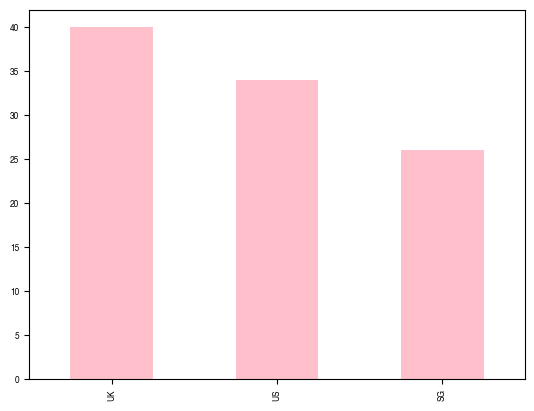

In [336]:
#plot customer country for the 100 customers
data_cust.customer_country.value_counts().plot(kind='bar', color='pink')

In [337]:
## Counterparty Country

data.counterparty_country.value_counts().to_frame()

## We can see that United States, US and USA are included. 
## Hence, there is a need to change United States and US to USA

,counterparty_country
CN,619
UK,614
JP,537
US,494
DE,484
FR,455
HK,453
BR,392
SG,375
IN,340


In [338]:
data['counterparty_country'] = data['counterparty_country'].replace(['United States', 'US'], 'USA')

<AxesSubplot: title={'center': 'Total Number of Counterparties per Country'}>

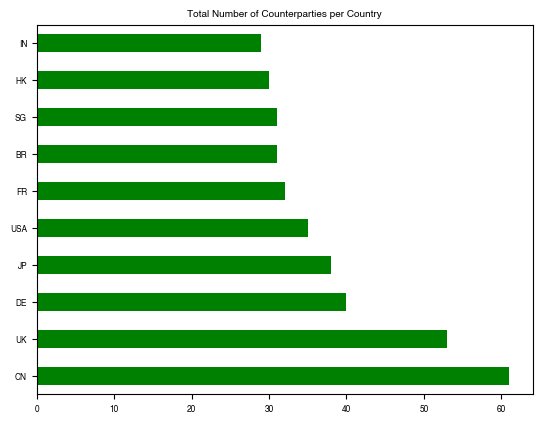

In [339]:
#plot counterparty country based on unique counterparties
data.drop_duplicates(subset=['counterparty','counterparty_country']).reset_index(drop=True).counterparty_country.value_counts().plot(kind='barh', color = 'green', title='Total Number of Counterparties per Country')

<AxesSubplot: title={'center': 'Number of Fraud_Flag Transactions'}>

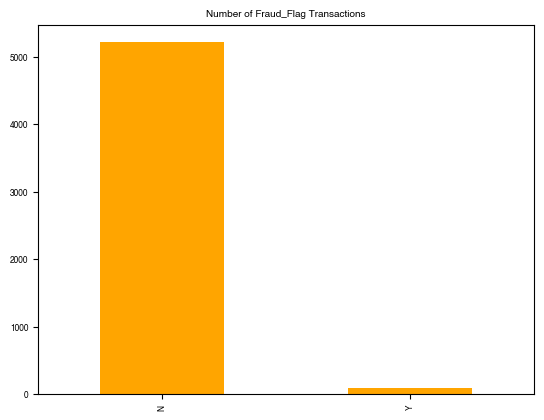

In [340]:
#plot value counts of y label
data.fraud_flag.value_counts().plot(kind='bar',title="Number of Fraud_Flag Transactions", color='orange')

In [341]:
## Since Yes value is low for fraud_flag, we can do oversampling of minority class

<AxesSubplot: title={'center': 'Count of Transaction Types'}>

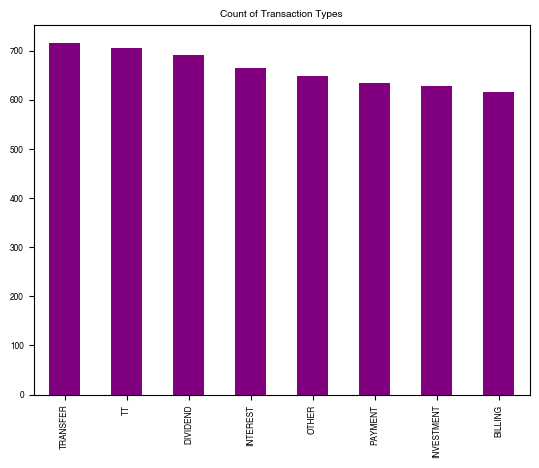

In [342]:
#plot count of different transaction types
data.type.value_counts().plot(kind='bar', color = 'purple',title="Count of Transaction Types")

<AxesSubplot: title={'center': 'Distribution of fraud_flag per transaction type'}, xlabel='type'>

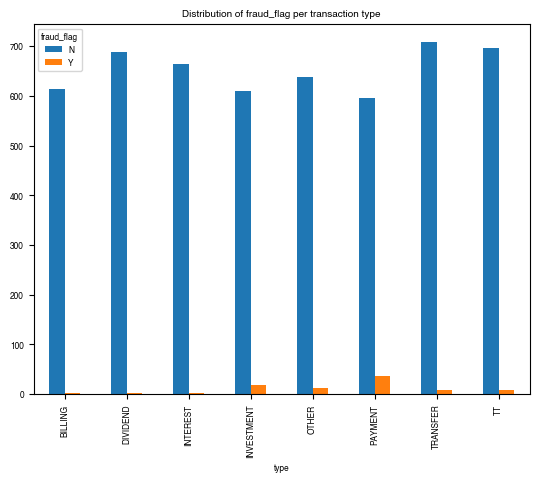

In [343]:
## Visualise distribution of fraud_flag value for each transaction type
(data
 .groupby(['type', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(title="Distribution of fraud_flag per transaction type")
)

<AxesSubplot: title={'center': 'Distribution of fraud_flag per currency type'}, xlabel='ccy'>

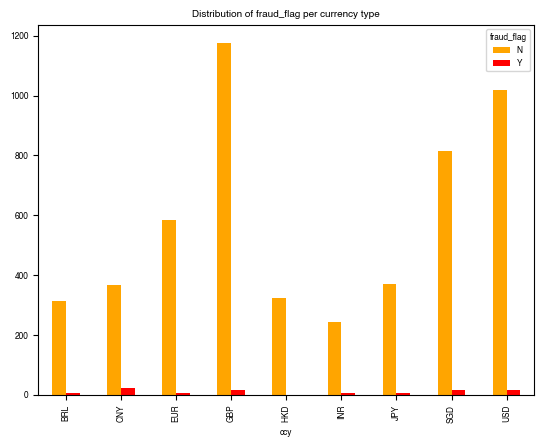

In [344]:
#plot count of types of currency
## Visualise distribution of fraud_flag value for currency type
(data
 .groupby(['ccy', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(color=['orange','red'],title="Distribution of fraud_flag per currency type")
)

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

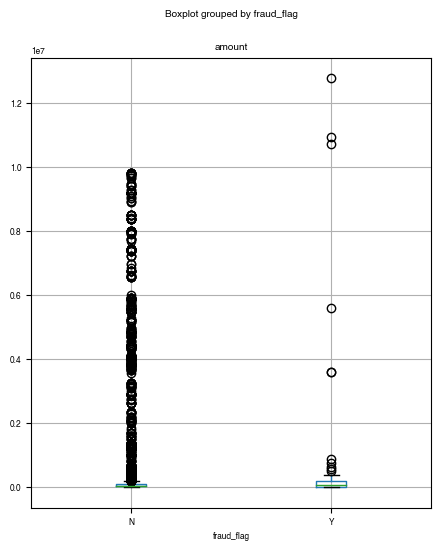

In [345]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

In [346]:
## create new column for month_year
data['month_year'] = pd.to_datetime(data['timestamp']).dt.to_period('M')
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09


In [347]:
## create new column for time of day
def timeofday(x):
    if (x>=0) & (x<6):
        tod = 'night'
    elif (x>=6) & (x<12):
        tod = 'morning'
    elif (x>=12) & (x<18):
        tod = 'afternoon'
    else:
        tod = 'evening'
    return tod

In [348]:
## create new column to map time of day
data['time'] = data.timestamp.dt.hour.map(timeofday) 

In [349]:
data.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,counterparty_country,type,ccy,amount,month_year,time
0,C12976926337644,UK,N,2021-03-20 05:59:25,77697395249488,CN,OTHER,JPY,48625.25,2021-03,night
1,C12976926337644,UK,N,2021-05-02 03:00:38,77697395249488,CN,PAYMENT,GBP,20637.21,2021-05,night
2,C12976926337644,UK,N,2021-05-23 22:15:15,77697395249488,NaN,PAYMENT,USD,56691.27,2021-05,evening
3,C12976926337644,UK,N,2021-07-07 21:36:50,77697395249488,NaN,PAYMENT,CNY,343864.71,2021-07,evening
4,C12976926337644,UK,N,2021-09-02 00:14:03,77697395249488,NaN,PAYMENT,USD,57247.35,2021-09,night


<AxesSubplot: title={'center': 'Fraud_flag transactions per month'}, xlabel='month_year'>

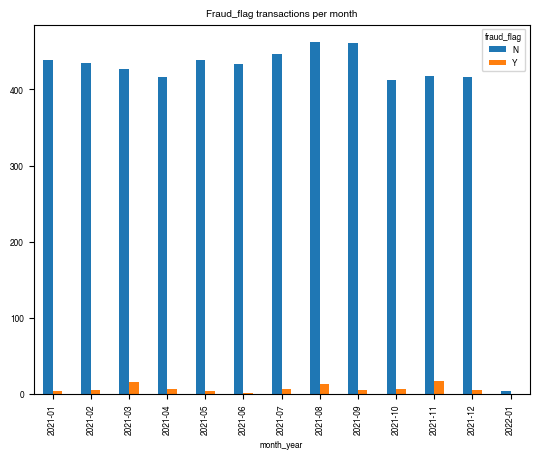

In [350]:
## Visualise distribution of fraud_flag values for each month
(data
 .groupby(['month_year', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(title="Fraud_flag transactions per month")
)

<AxesSubplot: title={'center': 'Fraud_flag transactions per time of day'}, xlabel='time'>

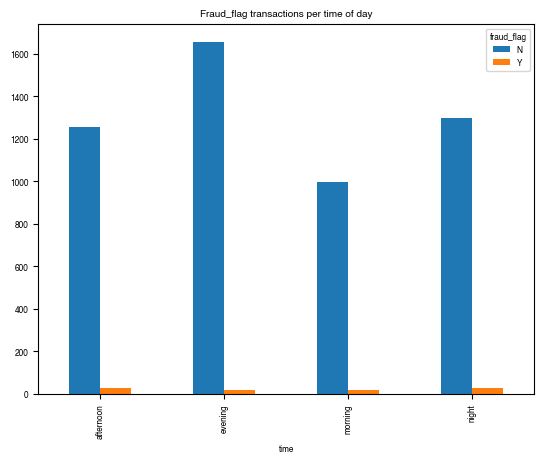

In [351]:
## Visualise distribution of fraud_flag values for time of day
(data
 .groupby(['time', 'fraud_flag'])
 .size()
 .unstack()
 .plot.bar(title="Fraud_flag transactions per time of day")
)

In [352]:
## REMAP y value to integers (0,1)
data['fraud_flag'] = [0 if x == 'N' else 1 for x in data['fraud_flag']]

### Modelling

### Model 1:
#### Drop NaN values

In [353]:
## We keep the counterparty_country as one of our features in the model. Hence we remove the NaN values and drop 499 rows
## I have tried another model where I removed the counterparty column and kept the 499 rows.
## However, the output and feature importance scores are similar, hence I will demonstrate my analysis with this model.

## Model 2 will keep the 499 rows along with further feature pre-processing.

In [354]:
## drop na values
data_model = data.dropna().reset_index(drop=True)

In [355]:
## identify correlation between any features in df
data_model.corr()

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_13821/1006686231.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_model.corr()


,fraud_flag,counterparty,amount
fraud_flag,1.000000,0.009020,0.012756
counterparty,0.009020,1.000000,-0.035139
amount,0.012756,-0.035139,1.000000


In [356]:
## For further data cleaning, we will do remapping of our binary features and creating dummy variables for our categorical features
## We will follow up with oversampling the minority class using SMOTE

In [357]:
# Create dummy variables
dummy_customer_country = pd.get_dummies(data_model['customer_country'], prefix='cust_country', drop_first=True)
dummy_counterparty_country = pd.get_dummies(data_model['counterparty_country'], prefix='count_country', drop_first=True)
dummy_type = pd.get_dummies(data_model['type'], prefix='type', drop_first=True)
dummy_ccy = pd.get_dummies(data_model['ccy'], prefix='ccy', drop_first=True) 

In [358]:
# Drop unnecessary columns
to_drop = ['customer', 'customer_country', 'timestamp', 'counterparty',
           'counterparty_country', 'type', 'ccy','month_year','time']
data_model.drop(to_drop, axis=1, inplace=True)

In [359]:
data_model.head()

,fraud_flag,amount
0,0,48625.25
1,0,20637.21
2,0,36944.25
3,0,48653.70
4,0,48765.81


In [360]:
# Merge dataframes into a single dataframe
merged_df = pd.concat([dummy_ccy,dummy_type,dummy_counterparty_country,dummy_customer_country,data_model], axis=1)
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48625.25
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,20637.21
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,36944.25
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48653.70
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,48765.81


In [361]:
## use MinMaxScaler to handle the large values of amount, 
## since machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data_model.columns if data_model[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df[col] = scaled[col]
    
merged_df.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,count_country_HK,count_country_IN,count_country_JP,count_country_SG,count_country_UK,count_country_USA,cust_country_UK,cust_country_US,fraud_flag,amount
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003799
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.001608
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002885
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003802
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003810


In [362]:
## create model using SMOTE to oversample minority class

## Naive Approach

X = merged_df.drop('fraud_flag', axis=1)
y = merged_df['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.69
% Positive class in Test  = 1.67


##### We will start off with a simple Random Forest model, not accounting for class imbalance

##### Since we are focusing on fraudulent transactions, we want to ensure we identify all True positives accurately, hence we want to minimise our fall negative (FN) count.

##### Main metric of evaluation should therefore be Recall = (TP/TP+FN)

Accuracy = 0.99
Recall = 0.40
Precision = 1.00



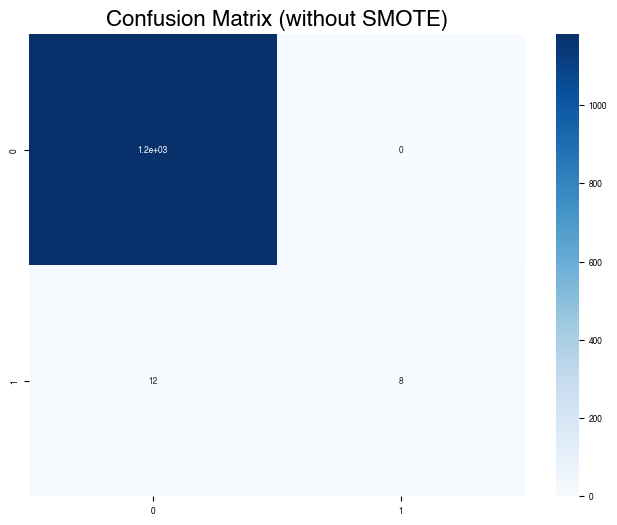

In [363]:
# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

##### As we can see for the simple random forest model, the model is being overfitted and is predicting the majority class, which is Y=0. Hence,there is a need to handle class imbalance for our minority class.

In [364]:
## handle class imbalance

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4803, 27)
Shape of X after SMOTE: (9444, 27)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 0.99
Recall = 0.99
Precision = 0.99



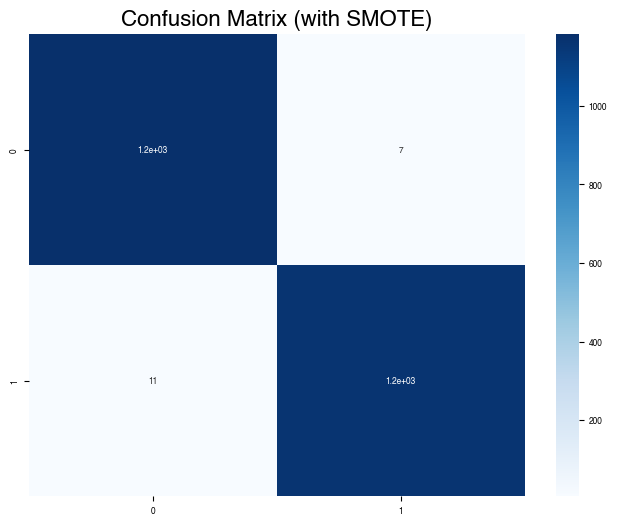

In [365]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

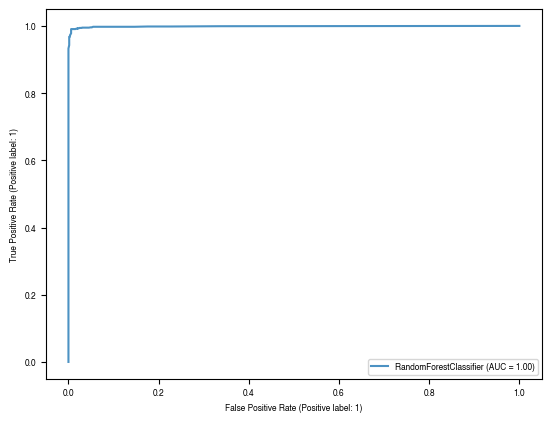

In [366]:
# plot auc-roc curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)

##### After handling class imbalance, the model performs better with a recall of 0.99.

In [367]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) amount                         0.259184
 2) type_PAYMENT                   0.065186
 3) cust_country_UK                0.054732
 4) count_country_JP               0.047096
 5) type_DIVIDEND                  0.047005
 6) type_INTEREST                  0.043502
 7) ccy_CNY                        0.038917
 8) ccy_USD                        0.037231
 9) cust_country_US                0.035012
10) type_INVESTMENT                0.027202
11) type_OTHER                     0.026739
12) ccy_GBP                        0.026045
13) count_country_CN               0.025877
14) ccy_HKD                        0.023911
15) type_TRANSFER                  0.023700
16) ccy_SGD                        0.022445
17) type_TT                        0.021074
18) count_country_IN               0.020616
19) ccy_JPY                        0.020093
20) count_country_DE               0.019620
21) count_country_SG               0.019530
22) count_country_UK               0.019375
23) count_country_HK            

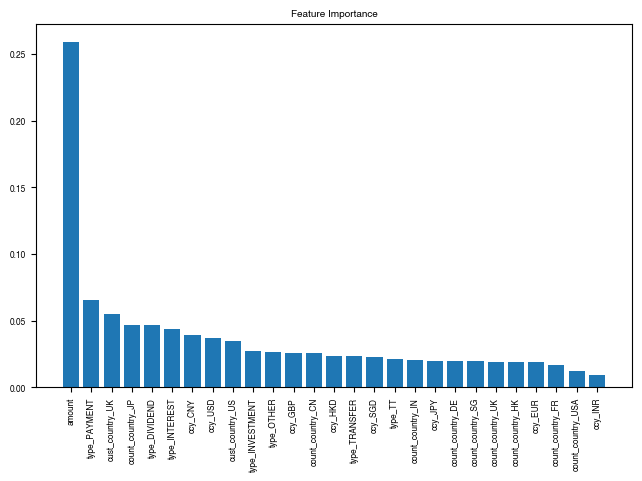

In [368]:
## Visualise feature importance scores
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

##### We can see from the feature importance scores that the **amount** column plays a key role in identifying fraudulent transactions.
##### However, based from our EDA, we notice that is difficult to identify fraudulent transactions just from the **amount** column given the large overlap in values from our boxplot.

##### Showcased below is the boxplot of the relationship between **fraud_flag** and **amount**.

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

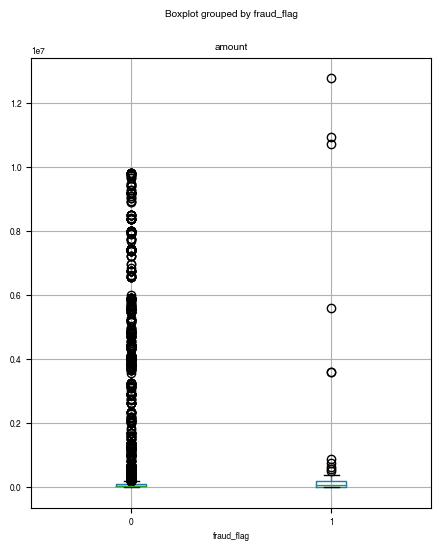

In [369]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

## Model 2
### Add in new features

##### I will be adding two new columns, based on the customer's and counterparty's history of having fraudulent transactions before.
##### I will be taking the **mean** of the fraud_flag for each customer and counterparty respectively. 

##### I will also remove the counterparty column, hence the 499 rows will be kept.

In [370]:
## identify mean of customer's fraudulent transactions history
customer_past_fraud = data.groupby('customer')['fraud_flag'].mean().to_frame().reset_index()
customer_past_fraud.columns = ['customer', 'fraud_past_cust']

customer_past_fraud.sort_values(by='fraud_past_cust',ascending=False).reset_index(drop=True).head()

,customer,fraud_past_cust
0,R35322123754253,0.230769
1,P52769772532121,0.207317
2,K65138125882614,0.176471
3,P45766486597685,0.152941
4,P68755181269737,0.109890


In [371]:
## identify mean of counterparty's fraudulent transactions history
counterparty_past_fraud = data.groupby('counterparty')['fraud_flag'].mean().to_frame().reset_index()
counterparty_past_fraud.columns = ['counterparty', 'fraud_past_counter']

counterparty_past_fraud.sort_values(by='fraud_past_counter',ascending=False).reset_index(drop=True).head()

,counterparty,fraud_past_counter
0,11361375457751,1.0
1,19119499953466,1.0
2,21197982847468,1.0
3,21246979492915,1.0
4,21691185267134,1.0


In [372]:
## merge the two newly created dfs to data df
data = pd.merge(data, customer_past_fraud, on="customer")
data = pd.merge(data, counterparty_past_fraud, on = "counterparty")

In [373]:
## drop counterparty column so that we do not need to drop any na values
data_model_2 = data.drop(['counterparty_country'],axis=1)
data_model_2.head()

,customer,customer_country,fraud_flag,timestamp,counterparty,type,ccy,amount,month_year,time,fraud_past_cust,fraud_past_counter
0,C12976926337644,UK,0,2021-03-20 05:59:25,77697395249488,OTHER,JPY,48625.25,2021-03,night,0.0,0.0
1,C12976926337644,UK,0,2021-05-02 03:00:38,77697395249488,PAYMENT,GBP,20637.21,2021-05,night,0.0,0.0
2,C12976926337644,UK,0,2021-05-23 22:15:15,77697395249488,PAYMENT,USD,56691.27,2021-05,evening,0.0,0.0
3,C12976926337644,UK,0,2021-07-07 21:36:50,77697395249488,PAYMENT,CNY,343864.71,2021-07,evening,0.0,0.0
4,C12976926337644,UK,0,2021-09-02 00:14:03,77697395249488,PAYMENT,USD,57247.35,2021-09,night,0.0,0.0


In [374]:
## get correlation of features in data_model_2
## we ignore counterparty since that is the counterparty id
data_model_2.corr()

/var/folders/fp/chskv2v95k13ldv_jpwqql9c0000gn/T/ipykernel_13821/3897801111.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_model_2.corr()


,fraud_flag,counterparty,amount,fraud_past_cust,fraud_past_counter
fraud_flag,1.000000,0.016388,0.010768,0.317809,0.779866
counterparty,0.016388,1.000000,-0.037123,-0.035168,0.021014
amount,0.010768,-0.037123,1.000000,-0.057128,0.004364
fraud_past_cust,0.317809,-0.035168,-0.057128,1.000000,0.407518
fraud_past_counter,0.779866,0.021014,0.004364,0.407518,1.000000


In [375]:
## Check multicollinearity amongst independent features using VIF

# VIF dataframe
vif_data = pd.DataFrame()
cols = data_model_2[["amount","fraud_past_cust","fraud_past_counter"]]
vif_data["feature"] = cols.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cols.values, i)
                          for i in range(len(cols.columns))]
  
print(vif_data)

## since there is low multicollinearity amongst features, we can use the 2 new features for our model (fraud_past_cust and fraud_past_counter)

              feature       VIF
0              amount  1.005609
1     fraud_past_cust  1.236617
2  fraud_past_counter  1.234601


In [376]:
# Create dummy variables (same preprocessing as model 1, excluding counterparty_country column)
# Since there are 499 new rows included as compared to model 1, the creation of dummy variables will be done again for analysis
dummy_customer_country_2 = pd.get_dummies(data_model_2['customer_country'], prefix='cust_country', drop_first=True)
dummy_type_2 = pd.get_dummies(data_model_2['type'], prefix='type', drop_first=True)
dummy_ccy_2 = pd.get_dummies(data_model_2['ccy'], prefix='ccy', drop_first=True) 

In [377]:
# Drop unnecessary columns
to_drop = ['customer','customer_country', 'timestamp', 'counterparty', 'type', 'ccy','month_year','time']
data_model_2.drop(to_drop, axis=1, inplace=True)

In [378]:
data_model_2

,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,48625.25,0.0,0.0
1,0,20637.21,0.0,0.0
2,0,56691.27,0.0,0.0
3,0,343864.71,0.0,0.0
4,0,57247.35,0.0,0.0
...,...,...,...,...
5297,0,25774.25,0.0,0.0
5298,0,25660.33,0.0,0.0
5299,0,32242.92,0.0,0.0
5300,0,32139.62,0.0,0.0


In [379]:
# Merge dataframes into a single dataframe
merged_df2 = pd.concat([dummy_ccy_2,dummy_type_2,dummy_customer_country_2,data_model_2], axis=1)
merged_df2.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,type_OTHER,type_PAYMENT,type_TRANSFER,type_TT,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,48625.25,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20637.21,0.0,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,56691.27,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,343864.71,0.0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,57247.35,0.0,0.0


In [380]:
## use MinMaxScaler to handle the large values of amount, 
## since machine learning algorithms will give more importance to variables on a larger scale

# Scale only columns that have values greater than 1
to_scale = [col for col in data_model_2.columns if data_model_2[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged_df2[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged_df2[col] = scaled[col]
    
merged_df2.head()

,ccy_CNY,ccy_EUR,ccy_GBP,ccy_HKD,ccy_INR,ccy_JPY,ccy_SGD,ccy_USD,type_DIVIDEND,type_INTEREST,...,type_OTHER,type_PAYMENT,type_TRANSFER,type_TT,cust_country_UK,cust_country_US,fraud_flag,amount,fraud_past_cust,fraud_past_counter
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0.003799,0.0,0.0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.001608,0.0,0.0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.004431,0.0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0.026915,0.0,0.0
4,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0.004474,0.0,0.0


In [381]:
## create model using SMOTE to oversample minority class

## Naive Approach

X = merged_df2.drop('fraud_flag', axis=1)
y = merged_df2['fraud_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Positive class in Train = 1.79
% Positive class in Test  = 1.51


In [382]:
## handle class imbalance for Model 2

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5302, 20)
Shape of X after SMOTE: (10422, 20)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: fraud_flag, dtype: float64

Accuracy = 1.00
Recall = 1.00
Precision = 1.00



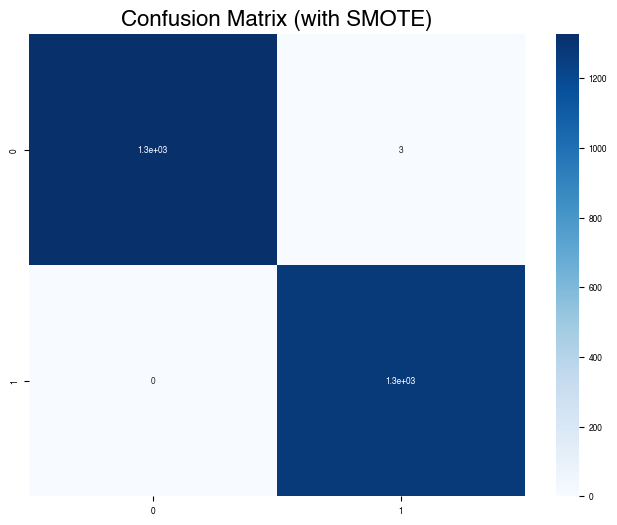

In [383]:
## random forest model with balanced dataset

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\nPrecision = {precision_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (with SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

## We notice that the accuracy, recall and precision are all very high, which will be discussed later.

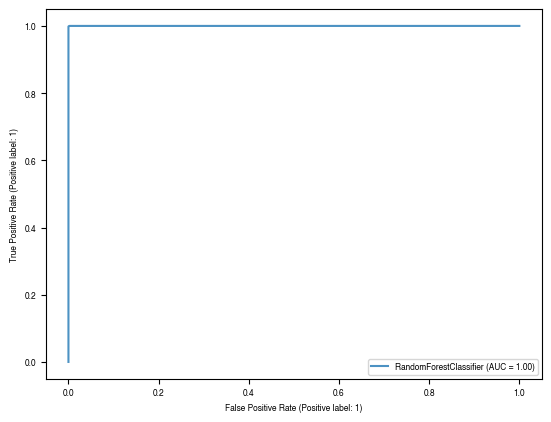

In [384]:
# plot auc-roc curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, alpha=0.8)

In [385]:
## feature importance scores

importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) fraud_past_counter             0.580362
 2) fraud_past_cust                0.250093
 3) amount                         0.043909
 4) type_PAYMENT                   0.021835
 5) type_INTEREST                  0.016618
 6) ccy_CNY                        0.010431
 7) type_DIVIDEND                  0.010169
 8) cust_country_UK                0.009487
 9) ccy_SGD                        0.006729
10) ccy_HKD                        0.006720
11) type_OTHER                     0.005787
12) ccy_USD                        0.005687
13) ccy_GBP                        0.005518
14) cust_country_US                0.005369
15) type_INVESTMENT                0.004713
16) ccy_EUR                        0.004083
17) type_TRANSFER                  0.003863
18) type_TT                        0.003796
19) ccy_JPY                        0.002848
20) ccy_INR                        0.001984


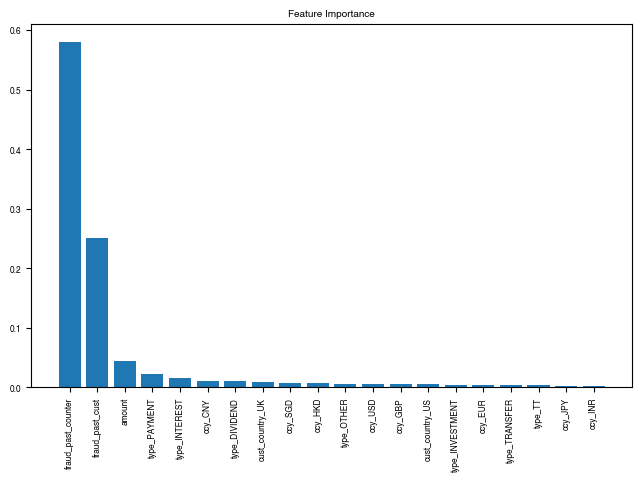

In [386]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Evaluation

##### Our main metric of evaluation is recall = (TP/TP+FN) given that we want to minimise the false negatives in terms of identifying fraudulent transactions. 

##### For Model 1, we notice that the **amount** column is a key indicator with regards to predicting fraudulent transactions. However, based on our EDA, we know that it is difficult to get some actionable and insightful analysis, given the large overlap of values between *fraud_flag = 0* and *fraud_flag = 1*. 

<AxesSubplot: title={'center': 'amount'}, xlabel='fraud_flag'>

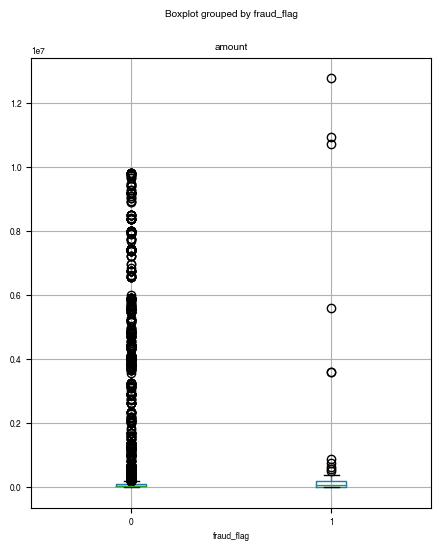

In [387]:
#box plot of relationship between fraud_flag and amount
data.boxplot(column='amount', by='fraud_flag', figsize=(5,6))

##### For Model 2, we created new columns based on the mean number of times each customer and counterparty had any fraudulent transactions respectively.
##### We notice that the counterparty's fraudulent history played a key role with regards to identifying fraudulent transactions from the feature importance scores.
##### The customer's fraudulent history also had a strong importance with regards to predicting the target output variable.

In [388]:
## we will plot the relationship between the customer's/counterparty's fraudulent history with our y variable (fraud_flag)
## create df copy to plot distribution for past customer/counterparty fraudulent history
data_model_vis = data_model_2.copy()

In [389]:
## round mean values to 1 dp for visualisation purposes
data_model_vis['fraud_past_cust_vis'] = data_model_vis['fraud_past_cust'].round(decimals = 1)
data_model_vis['fraud_past_counter_vis'] = data_model_vis['fraud_past_counter'].round(decimals = 1)

/Users/bhaveshchainani/virtualenv/silent_eight/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


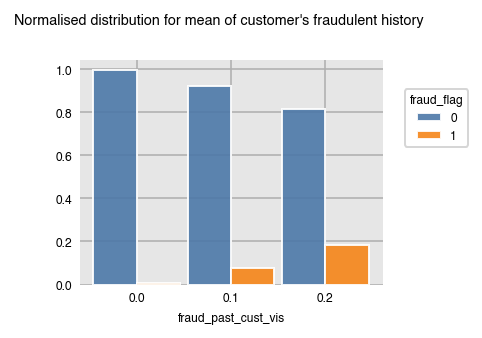

In [390]:
## Plot Normalised distribution for mean of customer's fraudulent history
dxp.count('fraud_past_cust_vis', data=data_model_vis, split='fraud_flag',normalize='fraud_past_cust_vis', title="Normalised distribution for mean of customer's fraudulent history")

/Users/bhaveshchainani/virtualenv/silent_eight/lib/python3.9/site-packages/dexplot/_common_plot.py:156: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  self.data[name].cat.remove_unused_categories(inplace=True)


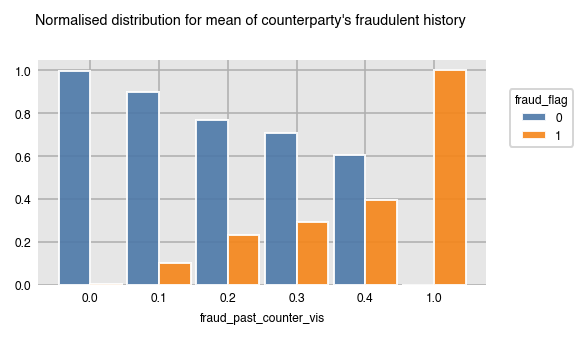

In [391]:
## Plot Normalised distribution for mean of counterparty's fraudulent history
dxp.count('fraud_past_counter_vis', data=data_model_vis, split='fraud_flag',normalize='fraud_past_counter_vis',title="Normalised distribution for mean of counterparty's fraudulent history")

##### From the above plots, we can see that if a customer or counterparty have had any past transaction history which is fraudulent, it plays a key role in predicting if any future transactions are fraudulent.

### Room for Improvement

##### We notice that the metric values for model 2 are very high. (precision, recall, accuracy)
##### This is because SMOTE has a disadvantage of:
#####   1) Oversampling uninformative samples
#####   2) Oversampling noisy samples

##### This leads to the possibility of overfitting, given that oversampling consists of making copies of existing examples. Hence there is a possibility to try undersampling or other forms of techniques to handle class imbalance.

##### Another room for improvement would be to try new features to incorporate into the model. Since we know that for past fraudulent history, we are incorporating the use of the dependent variable (fraud_flag), we could use other columns instead to prevent high collinearity between our columns and fraud_flag.

##### For example, we could look at transaction histories that have been made by the same customer but in different countries on the same day(potentially through a money mule accessing the same account)

##### We could also look at multiple transactions being done over a short period of time by the same customer/counterparty.

##### This would help us to identify important features while making sure we do not solely use the dependent variable. Through adding more data, we would able to maximise our recall score without overfitting our model.

### Bhavesh Chainani
### Data Scientist